In [1]:
import numpy as np
import numpy.polynomial.hermite_e as H
from scipy.stats import norm
from matplotlib import pyplot as plt
from IPython.display import display
%matplotlib inline

In [2]:
def Herm(n):
    coeffs=[0]*(n+1)
    coeffs[n]=1
    return coeffs

def inner_product(h1,h2):
    return lambda x: H.hermeval(x, H.hermemul(h1, h2))

In [3]:
def trapezoid_int(f,a,b,n=100):
    P= [a+i*(b-a)/n for i in range(0,n+1)]
    F= [1/2*np.abs(P[i+1] - P[i]) * (f(P[i+1]) + f(P[i])) for i in range(0,n)]
    return sum(F)
'''def trapezoid_int(f, a, b, n):
    h = float(b-a)/n
    result = 0.5*f(a) + 0.5*f(b)
    for i in range(1, n):
        result += f(a + i*h)
    result *= h
    return result'''

'def trapezoid_int(f, a, b, n):\n    h = float(b-a)/n\n    result = 0.5*f(a) + 0.5*f(b)\n    for i in range(1, n):\n        result += f(a + i*h)\n    result *= h\n    return result'

In [4]:
def unif_icdf(params):
    a=params[0]
    b=params[1]
    return lambda u:u * (b-a) + a

def expo_icdf(params):
    return lambda u: -np.log(1-u)

def norm_icdf(params):
    return lambda u: norm.ppf(u, loc=0, scale=1)

In [5]:
def approximate_rv_coeffs(P, h):
    ki= [0]*P
    
    #set up gauss hermite quadrature
    m = P**2
    x,w = H.hermegauss(m)
    
    #compute the coefficients
    for i in range(0, P):
        #compute inner product with gauss hermite quadrature
        ip = sum([inner_product(Herm(i), Herm(i))(x[idx]) * w[idx] for idx in range(m)])
        #compute the integral
        integrand = lambda u: h(u) * H.hermeval(norm.ppf(u, loc=0, scale=1), Herm(i))
        ki[i]=np.sqrt(2*np.pi) / ip* trapezoid_int(integrand, 0.001, 1-0.001, 1000)
        
    return ki

In [6]:
def generate_rv(ki, S):
    #build out k termwise
    k= [0]*len(S)
    for i in range(len(ki)):
        k = np.add(k, ki[i]*H.hermeval(S, Herm(i)))
    return k

In [7]:
#generate a bunch of gaussian random variables to use
N= 5000
S=np.random.normal(loc=0, scale =1, size = N)

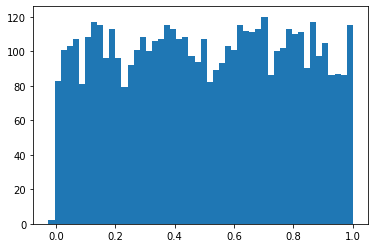

In [8]:
h = unif_icdf([0,1])
ki_uniform = approximate_rv_coeffs(13,h)
k= generate_rv(ki_uniform, S)
out = plt.hist(k, bins = 50)

In [9]:
ki_uniform

[0.49900000000000033,
 0.27875545086250536,
 -0.005128476292533232,
 -0.028199353280696664,
 -0.002759564058861633,
 0.000764364827382998,
 -0.0001484500275905018,
 -5.2907946579614456e-05,
 3.5672755268847944e-05,
 1.2271595198380592e-05,
 -9.22603591818783e-07,
 -1.0430068763532303e-06,
 -1.4481037273579921e-07]

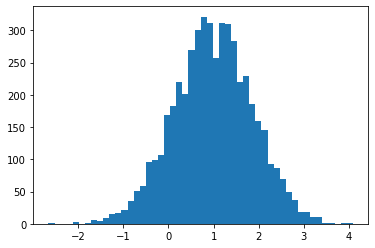

In [10]:
h = expo_icdf([0,1])
ki_expo = approximate_rv_coeffs(2,h)
k_expo = generate_rv(ki_expo, S)
out = plt.hist(k_expo, bins = 50)

In [11]:
def RK4(f, ic, tspan, h):
    t= [x * h for x in range(int((max(tspan) - min(tspan)) /h) + 1)]
    y= [ic]
    h2 = h/2
    for i in range(0,len(t)-1):
        y1 = f(t[i], y[i])
        y2 = f(t[i]+ h2, y[i] + np.multiply(h2, y1))
        y3 = f(t[i]+ h2, y[i] + np.multiply(h2, y2))
        y4 = f(t[i] + h, y[i] + np.multiply(h, y3))
        y.append( y[i] + np.multiply( h/6 , y1 + y4 + np.multiply(2, y2 + y3)))
    return t,y

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


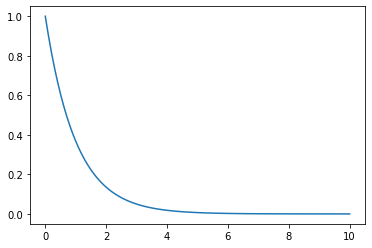

In [12]:
k=1
A = np.matrix([[-k]])
ode = lambda t, x : A * x
ic = np.matrix([1])
t,y = RK4(ode, ic, [0,10], 0.1)
y1 = [np.asscalar(x) for x in y]
plt.plot(t,y1)

# Monte Carlo Method

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


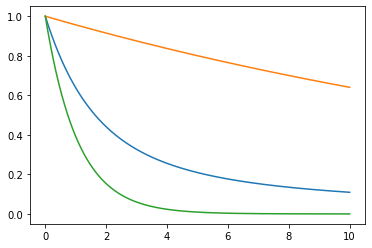

In [13]:
#monte carlo simulation
y_dmc = []
for k in range(1000):
    B = np.matrix([[-np.random.uniform(0,1)]])
    icb = np.matrix([1])
    odeb = lambda t,x: B*x
    t,y = RK4(odeb, icb, [0,10], 0.01)
    y_dmc.append([np.asscalar(x) for x in y])
    
plt.plot(t, np.mean(y_dmc, axis = 0))
plt.plot(t, np.percentile(y_dmc, axis = 0, q = 95))
plt.plot(t, np.percentile(y_dmc, axis = 0, q = 5))

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  import sys


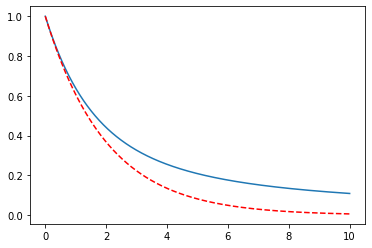

In [14]:
#comparison between stochastic mean and deterministic mean
plt.plot(t, np.mean(y_dmc, axis = 0))
B = np.matrix([[-0.5]])
icb = np.matrix([1])
odeb = lambda t,x: B*x
t,y = RK4(odeb, icb, [0,10], 0.01)
y_detmean = [np.asscalar(x) for x in y]
plt.plot(t, y_detmean, 'r--')

# Polynomial Chaos Expansion

In [15]:
def triple_product(h1, h2, h3):
    return lambda x: H.hermeval(x, H.hermemul(h1, H.hermemul(h2, h3)))

In [26]:
P = 5
A = np.matrix(np.zeros((P,P)))
m = P**3
x,w = H.hermegauss(m)

for l in range(P):
    ip = sum([inner_product(Herm(l), Herm(l))(x[idx]) * w[idx] for idx in range(m)])
    for j in range(P):
        for i in range(P):
            tp = sum([triple_product(Herm(i), Herm(j), Herm(l)) (x[idx]) * w[idx] for idx in range(m)])
            A[j,l] += -1 / ip * tp * ki_uniform[i]
ode = lambda t,x: A*x
ic = np.matrix(np.zeros((P,1)))
ic[0] = 1
t, y = RK4(ode, ic, [0,10], 0.01)
    

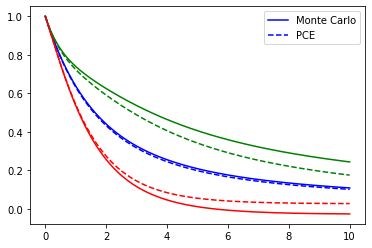

In [30]:
plt.plot(t, np.mean(y_dmc, axis = 0), 'b-', label="Monte Carlo")
plt.plot(t, np.mean(y_dmc, axis =0) + 3*np.var(y_dmc, axis = 0), 'g-')
plt.plot(t, np.mean(y_dmc, axis =0) - 3*np.var(y_dmc, axis = 0), 'r-')

y_pc_mean = [x[0,0] for x in y]
y_pc_var = [x[1,0]**2 for x in y]

plt.plot(t, y_pc_mean, 'b--',label="PCE")
plt.plot(t, np.add(y_pc_mean, np.multiply(3, y_pc_var)), 'g--')
plt.plot(t, np.add(y_pc_mean, np.multiply(-3, y_pc_var)), 'r--')
plt.legend(loc="upper right")
